<a href="https://colab.research.google.com/github/Joseline7/TFM-VIU-DeepLearning/blob/main/Copia_de_TFM_Joseline_Aguirre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Clasificación Multiclase de imágenes de ultrasonido de seno usando una red Profunda**

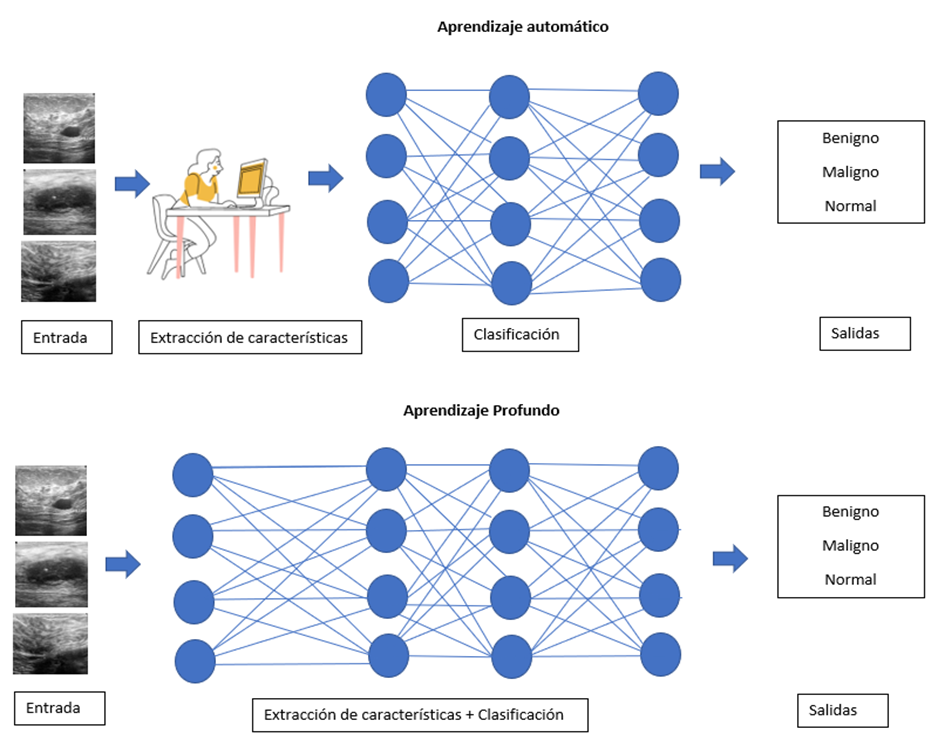


*-Benigno*
*-Maligno*
*-Normal*

# **Extración de imagenes del DRIVE**

In [1]:
from google.colab import drive
drive.mount('/content/drive')
print("Leyendo imagenes de: ", drive.mount)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Leyendo imagenes de:  <function mount at 0x7f7333b46e60>


# **Acontinuación empezamos con el modelo de red profunda**

# **IMPORTACIÓN DE LIBRERIAS**

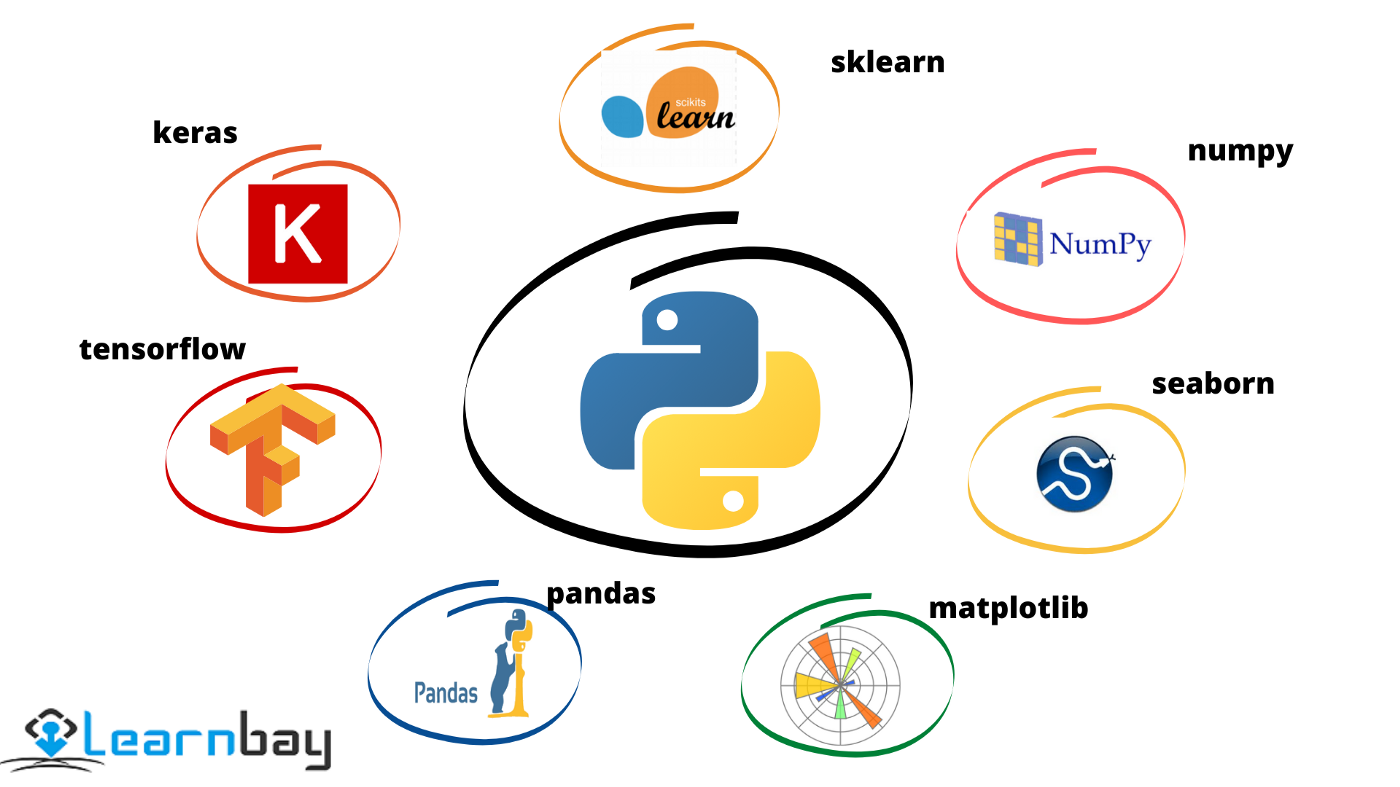

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os                           #files para obtener directorios y si tengo que eliminar algun file o algo en el folder  
import math                         #maps es usado para cualquier calculo matematico computacional
import shutil                       #se usa cuando quiero muever un file de un folder a otro 
import glob                         #deja ejecutar sin tener que escribir todo el path

from os.path import split

#LIBRERIA
import tensorflow as tf
import keras
import pandas as pd
#SECUENCIAL
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#MODELO
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.models import load_model

#GRÁFICA
import matplotlib.pyplot as plt

**Versión**

*   Tensor flow
*   Keras

In [3]:
print(tf.__version__)

2.9.2


In [4]:
print(keras.__version__)

2.9.0


**Revisión de lectura de número de imagenes a usar**

In [5]:
import pathlib
data_dir = pathlib.Path('/content/drive/MyDrive/Dataset_BUSI_with_GT')
#Imgenes -mask.png
count = len(list(data_dir.glob('*/*_mask.png')))
print("Número de imagenes con máscara:", count)
#Todas las imagenes .png
image_count = len(list(data_dir.glob('*/*.png')))
print("Número de datos tipo imagen:",image_count)

Número de imagenes con máscara: 780
Número de datos tipo imagen: 1578


**Revisión general de lista de imagenes**



In [6]:
df = list(data_dir.glob('*/*_mask.png'))
df = list(data_dir.glob('*/*.png'))

In [ ]:
df

# **Obtención y asignacion de dataset para entrenamiento**



*   Conjunto de entrenamiento
*   Conjunto de validación
*   Conjunto de prueba



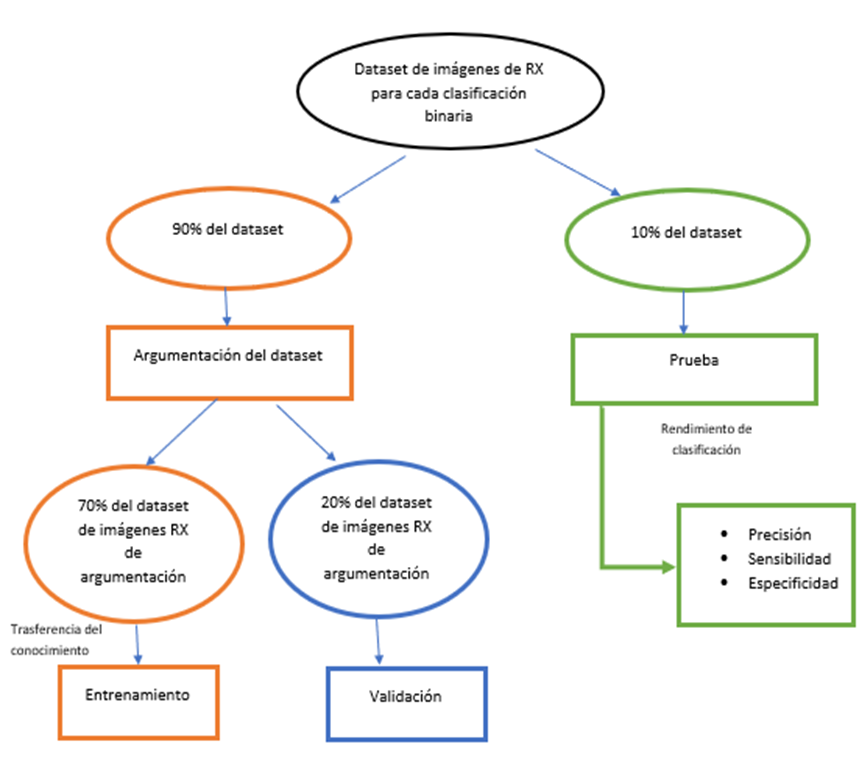


**Del conjunto de datos los parámetros para el cargador serán:**

Estandarizamos el dataset de imagenes

In [8]:
batch_size = 32
img_height = 180
img_width = 180

***Conjunto de entrenamiento***

In [44]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 1421 files for training.


***Conjunto de validación***

In [42]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 473 files for validation.


 ***Conjunto de prueba***

In [43]:
prueba_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.9,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1578 files belonging to 3 classes.
Using 158 files for training.


***Clases existentes en el dataset***

In [18]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant', 'normal']


# **DESARROLLO**
La división será: del 70% de las imágenes para entrenamiento,el 20% para validación y  un 10% de imagenes para prueba.

**Grafica representativa de distribución de dataset**

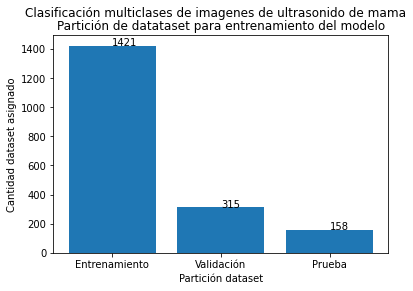

In [19]:
x = ["Entrenamiento", "Validación", "Prueba"]
y = [1421, 315, 158]
plt.bar( x, y)

def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i,y[i],y[i])
addlabels(x,y)   

plt.title("Partición de datataset para entrenamiento del modelo")
plt.suptitle("Clasificación multiclases de imagenes de ultrasonido de mama")
plt.xlabel("Partición dataset")
plt.ylabel("Cantidad dataset asignado")
plt.show( )

***Recordando al conjunto de validación***

In [20]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
print("")
print("Nombre de cada clase:")
#nombre de cada clase
class_names = train_ds.class_names
print(class_names)

Found 1578 files belonging to 3 classes.
Using 315 files for validation.

Nombre de cada clase:
['benign', 'malignant', 'normal']


**Demostramos que estamos trabajando con el dataset también indicamos la etiqueta correspondiente a cada una de ellas.**

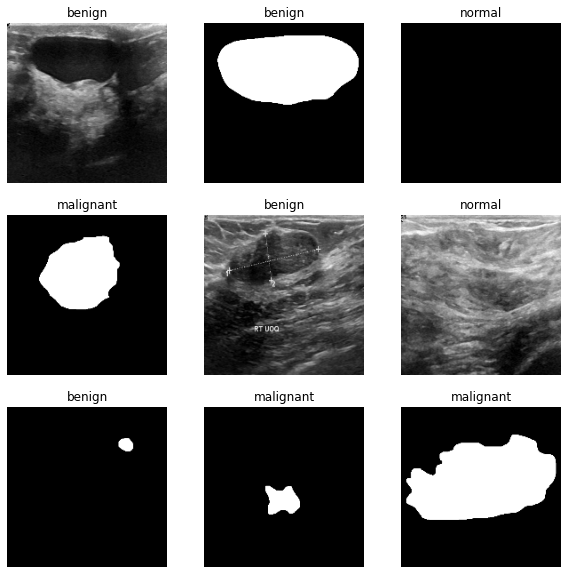

In [21]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**Información del número de imagenes correspondientes al lote ade más del tamaño asignado en las 3 clases**

In [24]:
for image_batch, labels_batch in train_ds:
  print("Tensor de forma: ","lote de 32 imágenes de forma 180 x 180 con dimensión RGB",image_batch.shape)
  print("Tensor de forma: ",labels_batch.shape)
  break

Tensor de forma:  lote de 32 imágenes de forma 180 x 180 con dimensión RGB (32, 180, 180, 3)
Tensor de forma:  (32,)


 **Estandarización de los datos**

**Se estandarizará los valores para que estén en el rango [0, 1]**:
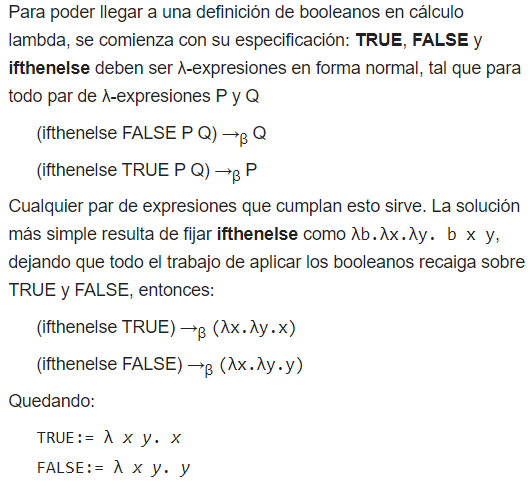

In [25]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [26]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
#ejemplo para primera imagen
first_image = image_batch[0]
print("Rango: ",np.min(first_image),"  a   ", np.max(first_image))

Rango:  0.0   a    1.0


 **Configurar el conjunto de datos para el rendimiento**

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
#mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
#superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Creación del modelo**

Para completar, se mostrará cómo se entrenó el modelo simplemente utilizando los conjuntos de datos que acabamos de preparar.

El modelo secuencial consta de tres bloques:

* Capa de convolución: ( tf.keras.layers.Conv2D ) 

* Capa de agrupación máxima: ( tf.keras.layers.MaxPooling2D ) en cada uno de  
  ellos.

* Hay una capa totalmente conectada ( tf.keras.layers.Dense ) con 128 unidades 
  encima que se activa mediante una función de activación de ReLU ( 'relu' ). 

Este modelo no se ha ajustado de ninguna manera todavía.

In [45]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes),
  
  #tf.keras.layers.Dense(2, activation ='softmax')
])

**Compilación del modelo**

Para la presición del entrenamiento y la validación de cada época de entrenamiento  se hace uso de:metrics a Model.compile, además de escoger el optimizador tf.keras.optimizers.Adam y la función de pérdida tf.keras.losses.SparseCategoricalCrossentropy. 

**Ajuste del modelo antes del entrenamiento**

In [46]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

**Entrenamiento del modelo con 10 epocas**

In [47]:
train_log = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30, batch_size=128
)

Epoch 1/30
45/45 [==============================] - 10s 180ms/step - loss: 0.8802 - accuracy: 0.5855 - val_loss: 0.6831 - val_accuracy: 0.6998
Epoch 2/30
45/45 [==============================] - 9s 173ms/step - loss: 0.6463 - accuracy: 0.7178 - val_loss: 0.5442 - val_accuracy: 0.7357
Epoch 3/30
45/45 [==============================] - 9s 176ms/step - loss: 0.4930 - accuracy: 0.7825 - val_loss: 0.4568 - val_accuracy: 0.7928
Epoch 4/30
45/45 [==============================] - 9s 174ms/step - loss: 0.4012 - accuracy: 0.8332 - val_loss: 0.3958 - val_accuracy: 0.8499
Epoch 5/30
45/45 [==============================] - 9s 175ms/step - loss: 0.2912 - accuracy: 0.8832 - val_loss: 0.3306 - val_accuracy: 0.9006
Epoch 6/30
45/45 [==============================] - 10s 208ms/step - loss: 0.2940 - accuracy: 0.8867 - val_loss: 0.3734 - val_accuracy: 0.9049
Epoch 7/30
45/45 [==============================] - 9s 174ms/step - loss: 0.1983 - accuracy: 0.9381 - val_loss: 0.2500 - val_accuracy: 0.9408
Epoc

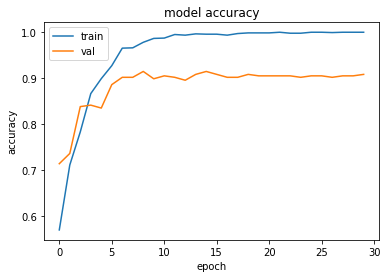

In [40]:
plt.plot(train_log.history['accuracy'])
plt.plot(train_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc="upper left")
plt.show()

 **Comprobando la presición del modelo**


*   Porcentaje de exactitud del entrenamiento del modelo
*   Porcentaje de perdida de la validación del modelo



In [48]:
test_loss, test_accuracy = model.evaluate(train_ds, )
print("Exactitud del entrenamiento del modelo: ", test_accuracy*100,"%")

print("")

test_loss, test_accuracy = model.evaluate(val_ds, )
print("Pérdida de la validación del modelo:  ", test_loss*100,"%")

45/45 [==============================] - 6s 119ms/step - loss: 0.0016 - accuracy: 0.9993
Exactitud del entrenamiento del modelo:  99.9296247959137 %

15/15 [==============================] - 2s 68ms/step - loss: 0.4356 - accuracy: 0.9514
Pérdida de la validación del modelo:   43.558287620544434 %


**Revisión del historial de los datos del entrenamiento para 10 iteraciones**

In [151]:
train_log.history

{'loss': [0.8838734030723572,
  0.6274001002311707,
  0.47040030360221863,
  0.32806962728500366,
  0.23210972547531128,
  0.1648394912481308,
  0.09466153383255005,
  0.08234424144029617,
  0.08973931521177292,
  0.0744853988289833,
  0.05601071938872337,
  0.02199685201048851,
  0.011565743014216423,
  0.014295910485088825,
  0.008024747483432293,
  0.0098274489864707,
  0.007757377345114946,
  0.009007800370454788,
  0.005561701022088528,
  0.004059994593262672,
  0.0050020706839859486,
  0.0027041728608310223,
  0.0022965355310589075,
  0.003058779053390026,
  0.003130788216367364,
  0.0034411707893013954,
  0.001527118613012135,
  0.002174174878746271,
  0.002471516840159893,
  0.0016329227946698666],
 'accuracy': [0.5897255539894104,
  0.7100633382797241,
  0.7994369864463806,
  0.8789584636688232,
  0.9064039587974548,
  0.9444053769111633,
  0.9690358638763428,
  0.9774806499481201,
  0.9774806499481201,
  0.9817030429840088,
  0.9866291284561157,
  0.9922589659690857,
  0.9971

**Modelo de precisión**

In [49]:
acc = model.evaluate_generator(train_ds)[1]
print(f"La precisión del modelo es: {acc*100}%")



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


La precisión del modelo es: 99.9296247959137%


In [50]:
h = train_log.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**Grafica representativa con datos normalizados**

In [51]:

actual = pd.Series(["accuracy","loss",], name = "Actual")
prede  = pd.Series(["val_accurancy","val_loss",], name = "Predecido")
df_confusion = pd.crosstab(actual,prede)
print(df_confusion)

Predecido  val_accurancy  val_loss
Actual                            
accuracy               1         0
loss                   0         1


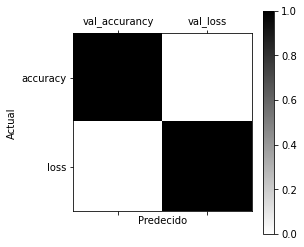

In [52]:

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=0)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)




**Grafica con la función de coste del modelo**

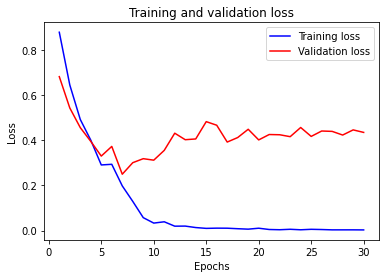

In [53]:
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Grafica de la exactitud del modelo**

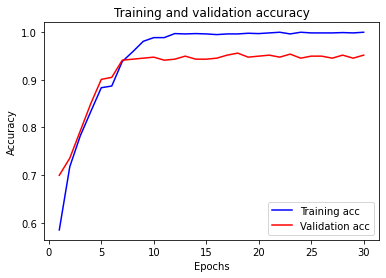

In [54]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Probando rendimiento del modelo con datos de prueba**

In [55]:
img_url = "https://images.app.goo.gl/WkuJqACx7ajWuWv57"
img_path = tf.keras.utils.get_file('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (90).png', origin=img_url)
#img_path = prueba_ds

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta imagen pertenece a la clase {} con un {:.2f} % de confidencialidad."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 201ms/step
Esta imagen pertenece a la clase benign con un 99.90 % de confidencialidad.


**Evaluación de desempeño**

In [109]:
accuracy = (0.541168212890625,
  0.6931738257408142,
  0.7558057904243469,
  0.8311048746109009,
  0.8796622157096863,
  0.9071076512336731,
  0.9380717873573303,
  0.9683321714401245,
  0.9683321714401245,
  0.9901477694511414)

valaccuracy = (0.6067653298377991,
  0.7293868660926819,
  0.830866813659668,
  0.8393234610557556,
  0.8752642869949341,
  0.8900634050369263,
  0.9133192300796509,
  0.915433406829834,
  0.9260042309761047,
  0.92811840772628788)

df1 = pd.DataFrame({"Precisión": accuracy, "Precisión Generada": valaccuracy})
df1.head(10)

#accuracy_total = np.mean(valaccuracy==accuracy)
#print(accuracy_total)

,Precisión,Precisión Generada
0,0.541168,0.606765
1,0.693174,0.729387
2,0.755806,0.830867
3,0.831105,0.839323
4,0.879662,0.875264
5,0.907108,0.890063
6,0.938072,0.913319
7,0.968332,0.915433
8,0.968332,0.926004
9,0.990148,0.928118


In [110]:
loss = (0.9056086540222168,
  0.7032356858253479,
  0.5383217930793762,
  0.4016938805580139,
  0.3296305537223816,
  0.24820446968078613,
  0.19526362419128418,
  0.10298838466405869,
  0.09314604848623276,
  0.03255141153931618)
 
valloss = (0.7844326496124268,
  0.6409218311309814,
  0.46175292134284973,
  0.45864930748939514,
  0.4007394015789032,
  0.41185373067855835,
  0.36329224705696106,
  0.3547987639904022,
  0.37892457842826843,
  0.4059711694717407)
 
df2 = pd.DataFrame({"Predida": loss, "Perdida Generada": valloss})
df2.head(10)


,Predida,Perdida Generada
0,0.905609,0.784433
1,0.703236,0.640922
2,0.538322,0.461753
3,0.401694,0.458649
4,0.329631,0.400739
5,0.248204,0.411854
6,0.195264,0.363292
7,0.102988,0.354799
8,0.093146,0.378925
9,0.032551,0.405971


In [159]:
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# *Matriz de confusion para primer modelo*

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


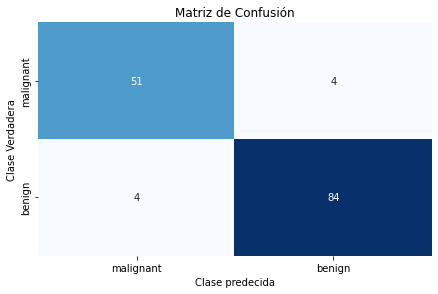

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        55
           1       0.95      0.95      0.95        88

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



In [ ]:

# Cargar datos
#iris = datasets.load_iris()
iris = datasets.load_breast_cancer()
#iris = train_log()
model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(tf.keras.optimizers.SGD(), loss='mse')
# create feature matrix
features = iris.data

# create target vector
target = iris.target

# create list of target class names
class_names = iris.target_names

# split into training and test sets
# Crear conjunto de prueba conjunto de prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=1)

# crear regresión logística Regresión logística
classifier = LogisticRegression()

# entrenar modelo y hacer predicciones
target_predicted = classifier.fit(features_train, target_train).predict(features_test)

# crear matriz de confusión
matrix = confusion_matrix(target_test, target_predicted)

# crear marco de datos de pandas Crear un conjunto de datos
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# crear mapa de calor dibujar mapa de calor

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de Confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase predecida")
plt.show()
inform = classification_report(target_test, target_predicted)
print(inform)

PRUEBAS

pruebas de entrenamiento correctas

# **Modelo secuencial**

**Técnica sin sobreajuste (primer modelo)**

Consta de tres bloques:

  -Convolución ( tf.keras.layers.Conv2D ).

  -Capa de agrupación máxima ( tf.keras.layers.MaxPooling2D ) en cada uno de    
   ellos. 

  -Capa totalmente conectada ( tf.keras.layers.Dense ) con 128 unidades encima 
   que se activa mediante una función de activación de ReLU ( 'relu' ). 


# *MODELO*

In [56]:
num_classes = len(class_names)
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  tf.keras.layers.Dense(3, activation ='softmax')
])

# *COMPILACIÓN*

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# *RESUMEN*

In [58]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

# *ENTRENAMIENTO DEL MODELO*

In [59]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


45/45 [==============================] - 11s 213ms/step - loss: 0.9746 - accuracy: 0.5595 - val_loss: 0.7455 - val_accuracy: 0.6321
Epoch 2/30
45/45 [==============================] - 9s 171ms/step - loss: 0.6861 - accuracy: 0.6671 - val_loss: 0.5524 - val_accuracy: 0.7949
Epoch 3/30
45/45 [==============================] - 9s 176ms/step - loss: 0.5283 - accuracy: 0.7825 - val_loss: 0.4793 - val_accuracy: 0.8309
Epoch 4/30
45/45 [==============================] - 9s 178ms/step - loss: 0.3898 - accuracy: 0.8417 - val_loss: 0.4224 - val_accuracy: 0.8520
Epoch 5/30
45/45 [==============================] - 9s 174ms/step - loss: 0.3397 - accuracy: 0.8663 - val_loss: 0.3810 - val_accuracy: 0.8858
Epoch 6/30
45/45 [==============================] - 9s 176ms/step - loss: 0.2379 - accuracy: 0.9177 - val_loss: 0.3752 - val_accuracy: 0.8943
Epoch 7/30
45/45 [==============================] - 9s 174ms/step - loss: 0.2039 - accuracy: 0.9303 - val_loss: 0.2956 - val_accuracy: 0.9175
Epoch 8/30
45/45

In [60]:
test_loss, test_accuracy = model.evaluate(train_ds, )
print("Exactitud del entrenamiento del modelo: ", test_accuracy*100,"%")

print("")

test_loss, test_accuracy = model.evaluate(val_ds, )
print("Pérdida de la validación del modelo:  ", test_loss*100,"%")

print("")


45/45 [==============================] - 6s 120ms/step - loss: 0.0039 - accuracy: 0.9993
Exactitud del entrenamiento del modelo:  99.9296247959137 %

15/15 [==============================] - 2s 67ms/step - loss: 0.5710 - accuracy: 0.9345
Pérdida de la validación del modelo:   57.10330605506897 %



# *VISUALIZACIÓN DE LOS RESULTADOS DEL ENTRENAMIENTO*

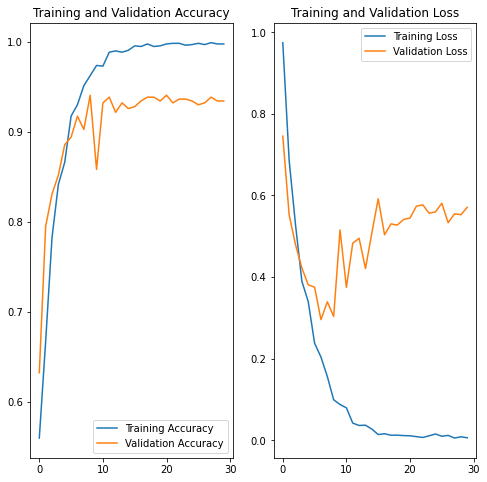

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

CONCLUSIÓN:
Los gráaficos demuestran que la presición del entrenamiento y la presición de validación se encuentran desvidos por un margen grande logrando solo un  73.5 % de presición.

# *Sobreajuste*
Entrenamiento con 15 epocas

In [62]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

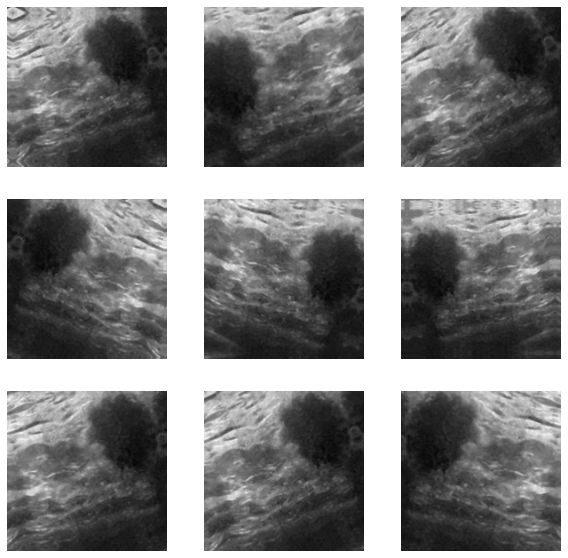

In [63]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Aplicación de DROPOUT

In [64]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
   tf.keras.layers.Dense(3, activation ='softmax')
])

# *COMPILACIÓN DEL MODELO*

In [65]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [66]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [68]:
epochs = 35
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/35
45/45 [==============================] - 9s 186ms/step - loss: 0.8847 - accuracy: 0.5827 - val_loss: 0.8058 - val_accuracy: 0.6596
Epoch 2/35
45/45 [==============================] - 9s 185ms/step - loss: 0.7444 - accuracy: 0.6714 - val_loss: 0.7282 - val_accuracy: 0.6956
Epoch 3/35
45/45 [==============================] - 11s 218ms/step - loss: 0.6967 - accuracy: 0.6826 - val_loss: 0.6332 - val_accuracy: 0.7230
Epoch 4/35
45/45 [==============================] - 9s 184ms/step - loss: 0.6516 - accuracy: 0.6988 - val_loss: 0.6191 - val_accuracy: 0.7061
Epoch 5/35
45/45 [==============================] - 9s 183ms/step - loss: 0.6360 - accuracy: 0.7150 - val_loss: 0.6794 - val_accuracy: 0.7061
Epoch 6/35
45/45 [==============================] - 9s 185ms/step - loss: 0.6199 - accuracy: 0.7262 - val_loss: 1.1267 - val_accuracy: 0.5814
Epoch 7/35
45/45 [==============================] - 9s 184ms/step - loss: 0.6051 - accuracy: 0.7354 - val_loss: 0.6970 - val_accuracy: 0.7040
Epoch

In [69]:
test_loss, test_accuracy = model.evaluate(train_ds, )
print("Exactitud del entrenamiento del modelo: ", test_accuracy*100,"%")

print("")

test_loss, test_accuracy = model.evaluate(val_ds, )
print("Pérdida de la validación del modelo:  ", test_loss*100,"%")


45/45 [==============================] - 6s 118ms/step - loss: 0.2620 - accuracy: 0.8923
Exactitud del entrenamiento del modelo:  89.23293352127075 %

15/15 [==============================] - 2s 67ms/step - loss: 0.2835 - accuracy: 0.8858
Pérdida de la validación del modelo:   28.352254629135132 %


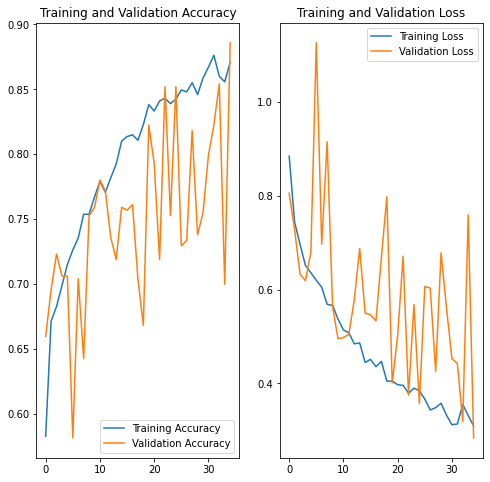

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# *Prueba del modelo con nuevos datos*

In [71]:
img_url = "https://images.app.goo.gl/WkuJqACx7ajWuWv57"
img_path = tf.keras.utils.get_file('/content/drive/MyDrive/Dataset_BUSI_with_GT/benign/benign (10)_mask.png', origin=img_url)
#img_path = prueba_ds

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "Esta imagen pertenece a la clase {} con un {:.2f} % de confidencialidad."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 143ms/step
Esta imagen pertenece a la clase malignant con un 51.24 % de confidencialidad.


# **FIN**

# ***Matriz de confusión***

In [ ]:
imagen = datasets.load_breast_cancer()
features = datasets.data
target = datasets.load_breast_cancer
class_names = datasets.load_breast_cancer

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


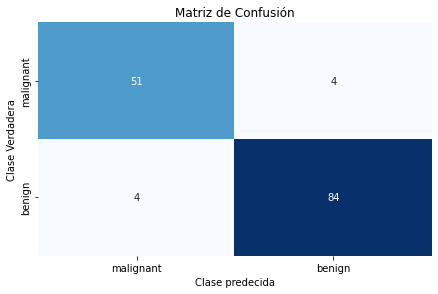

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        55
           1       0.95      0.95      0.95        88

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



In [ ]:
# Cargar datos
#iris = datasets.load_iris()
iris = datasets.load_breast_cancer()

# create feature matrix
features = iris.data

# create target vector
target = iris.target

# create list of target class names
class_names = iris.target_names

# split into training and test sets
# Crear conjunto de prueba conjunto de prueba
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=1)

# crear regresión logística Regresión logística
classifier = LogisticRegression()

# entrenar modelo y hacer predicciones
target_predicted = classifier.fit(features_train, target_train).predict(features_test)

# crear matriz de confusión
matrix = confusion_matrix(target_test, target_predicted)

# crear marco de datos de pandas Crear un conjunto de datos
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# crear mapa de calor dibujar mapa de calor

sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Matriz de Confusión"), plt.tight_layout()
plt.ylabel("Clase Verdadera"), plt.xlabel("Clase predecida")
plt.show()
inform = classification_report(target_test, target_predicted)
print(inform)

otras pruebas

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape = [224, 224,3]),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(2, activation ='softmax')
])

In [ ]:
def get_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(1, activation = 'linear', input_dim = 784))
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.1), loss='mean_squared_error', metrics=['mae'])
  return model

In [ ]:
import datetime

class MyCustomCallback(tf.keras.callbacks.Callback):

  def on_train_batch_begin(self, batch, logs=None):
    print('Entrenamiento: batch {} comienza en {}'.format(batch, datetime.datetime.now().time()))

  def on_train_batch_end(self, batch, logs=None):
    print('Entrenamiento: batch {} termina en {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_begin(self, batch, logs=None):
    print('Evaluacion: batch {} comienza en {}'.format(batch, datetime.datetime.now().time()))

  def on_test_batch_end(self, batch, logs=None):
    print('Evaluacion: batch {} termina en {}'.format(batch, datetime.datetime.now().time()))

In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

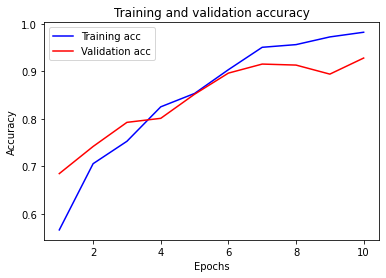

In [ ]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

CNN

In [ ]:
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

In [ ]:
def getProbsAndPreds(someX):
    probs = softmax(np.dot(someX,w))
    preds = np.argmax(probs,axis=1)
    return probs,preds

In [ ]:
train_log = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10, batch_size=128
)

In [ ]:
test_loss, test_accuracy = model.evaluate(train_ds, )
print("Exactitud del entrenamiento del modelo:", test_accuracy*100,"%")
test_loss, test_accuracy = model.evaluate(val_ds, )
print("Exactitud de la vlidación del modelo:", test_accuracy*100,"%")

35/35 [==============================] - 7s 188ms/step - loss: 0.0039 - accuracy: 0.9982
Exactitud del entrenamiento del modelo: 99.81900453567505 %
15/15 [==============================] - 3s 187ms/step - loss: 2.9520 - accuracy: 0.7442
Exactitud de la vlidación del modelo: 74.41860437393188 %


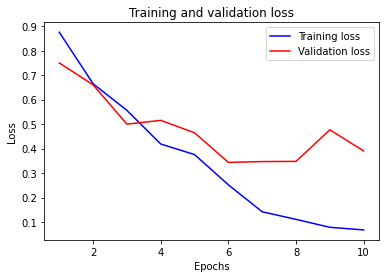

In [ ]:
loss = train_log.history['loss']
val_loss = train_log.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

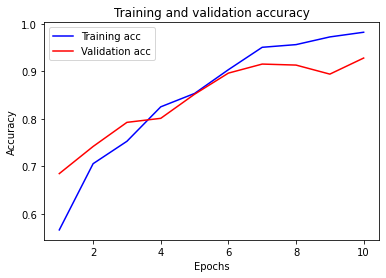

In [ ]:
plt.clf()
acc = train_log.history['accuracy']
val_acc = train_log.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(train_ds)
print("Clase más probable:", np.argmax(predictions[0]) )

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp.sum(axis=-1, keepdims=True)

# **Uso de tf.data para un control más preciso**

La utilidad de preprocesamiento de Keras anterior, tf.keras.utils.image_dataset_from_directory , es una forma conveniente de crear un tf.data.Dataset a partir de un directorio de imágenes.

Para un control de grano más fino, puede escribir su propia canalización de entrada usando tf.data . Esta sección muestra cómo hacerlo, comenzando con las rutas de archivo del archivo TGZ que descargó anteriormente.

In [ ]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/content/drive/MyDrive/TFM/dataset/Dataset_BUSI_with_GT/malignant/malignant (53)_mask_1.png'
b'/content/drive/MyDrive/TFM/dataset/Dataset_BUSI_with_GT/malignant/malignant (107).png'
b'/content/drive/MyDrive/TFM/dataset/Dataset_BUSI_with_GT/benign/benign (408).png'
b'/content/drive/MyDrive/TFM/dataset/Dataset_BUSI_with_GT/benign/benign (407).png'
b'/content/drive/MyDrive/TFM/dataset/Dataset_BUSI_with_GT/normal/normal (40).png'


La estructura de árbol de los archivos se puede utilizar para compilar una lista de nombres de class_names .

In [ ]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['benign' 'malignant' 'normal']


Dividiremos el conjunto de datos en conjuntos de entrenamiento y validación:

In [ ]:
val_size = int(image_count * 0.3)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

Puede imprimir la longitud de cada conjunto de datos de la siguiente manera:

In [ ]:
print("Número de datos de entrenamiento:",tf.data.experimental.cardinality(train_ds).numpy())
print("Número de datos de validación:", tf.data.experimental.cardinality(val_ds).numpy())

Número de datos de entrenamiento: 1105
Número de datos de validación: 473


Escriba una función breve que convierta una ruta de archivo en un par (img, label) :

In [ ]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use Dataset.map para crear un conjunto de datos de pares de image, label :

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in train_ds.take(1):
  print("Dimesiones: ", image.numpy().shape)
  print("Etiqueta:   ", label.numpy())

Dimesiones:  (180, 180, 3)
Etiqueta:    0


Configurar el conjunto de datos para el rendimiento
Para entrenar un modelo con este conjunto de datos.

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

# **Visualiza los datos**

In [ ]:
image_batch, label_batch = next(iter(train_ds))

Puede visualizar este conjunto de datos de la sigueinente manera:

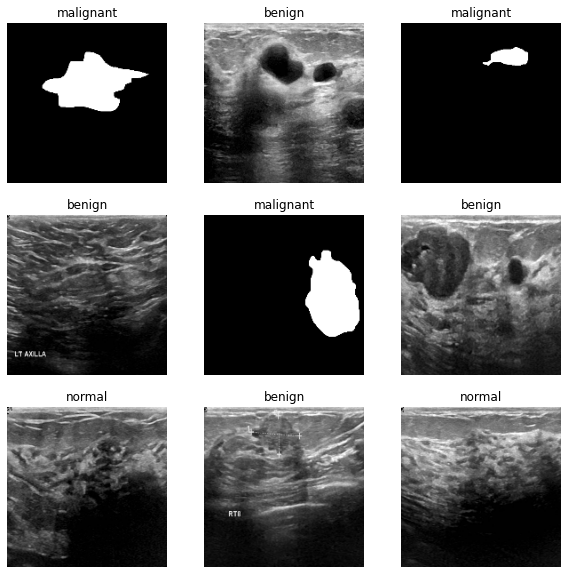

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# **Softmax**

Ahora ha creado manualmente un tf.data.Dataset similar al creado por tf.keras.utils.image_dataset_from_directory arriba. Puedes seguir entrenando al modelo con él. Como antes, entrenarás durante unas pocas épocas para que el tiempo de ejecución sea corto.

Aplicando foftmax 

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp.sum(axis=-1, keepdims=True)

In [ ]:
class Perceptron():
  def __init__(self, inputs, outputs):
    self.w = np.random.normal(loc=0.0, 
          scale = np.sqrt(2/(inputs+outputs)), 
          size = (inputs, outputs)) 
    self.ws = []
    self.loss = crossentropy
    self.grad_loss = grad_crossentropy
    
  def __call__(self, w, x):
    return np.dot(x, w) 

  def fit(self, x, y, epochs, lr, verbose=True, log_each=1):
    x = np.c_[np.ones(len(x)), x]
    for epoch in range(1,epochs+1):
        # Batch Gradient Descent
        y_hat = self(self.w, x)  
        # función de pérdida
        l = self.loss(y_hat, y).mean()
        # derivadas
        dldh = self.grad_loss(y_hat, y)
        dhdw = x
        dldw = np.dot(dhdw.T, dldh)
        # actualizar pesos
        self.w = self.w - lr*dldw
        # guardar pesos para animación
        self.ws.append(self.w.copy())
        # print loss
        if verbose and not epoch % log_each:
            print(f"Epoch {epoch}/{epochs} Loss {l}")
            
  def predict(self, x):
    x = np.c_[np.ones(len(x)), x]
    return self(self.w, x)

# **Matriz de confusión**

In [ ]:
plt.figure(figsize=(5, 4))
sns.heatmap(train_ds)
plt.title('Matriz de confusión')
plt.ylabel('Valores reales')
plt.xlabel('Valores previstos')
plt.mostrar()

In [ ]:
import numpy as np
import os
import re
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#se cambió from keras.utils import to_categorical
#from keras.utils import multi_gpu_utils
#from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
#from keras.layers.advanced_activations import LeakyReLU
#librería para matriz de confusión
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix